<a href="https://github.com/navant/decluttr/blob/main/src/notebooks/decluttr-exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Google's Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex



In [ ]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.5/966.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

##  Use Gemini to understand Images from URLs

In [ ]:
import os

GOOGLE_API_KEY = ""  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
IMAGE_FOLDER_PATH = '/content/drive/MyDrive/Colab Notebooks/Images'
image_path_fn = lambda x : f'{IMAGE_FOLDER_PATH}/{x}'

toys.jpg
sofa.jpg
kennel.jpg
run thing.jpg
bunch-colored-pencils-handmade-bright-cup-39580701.jpg


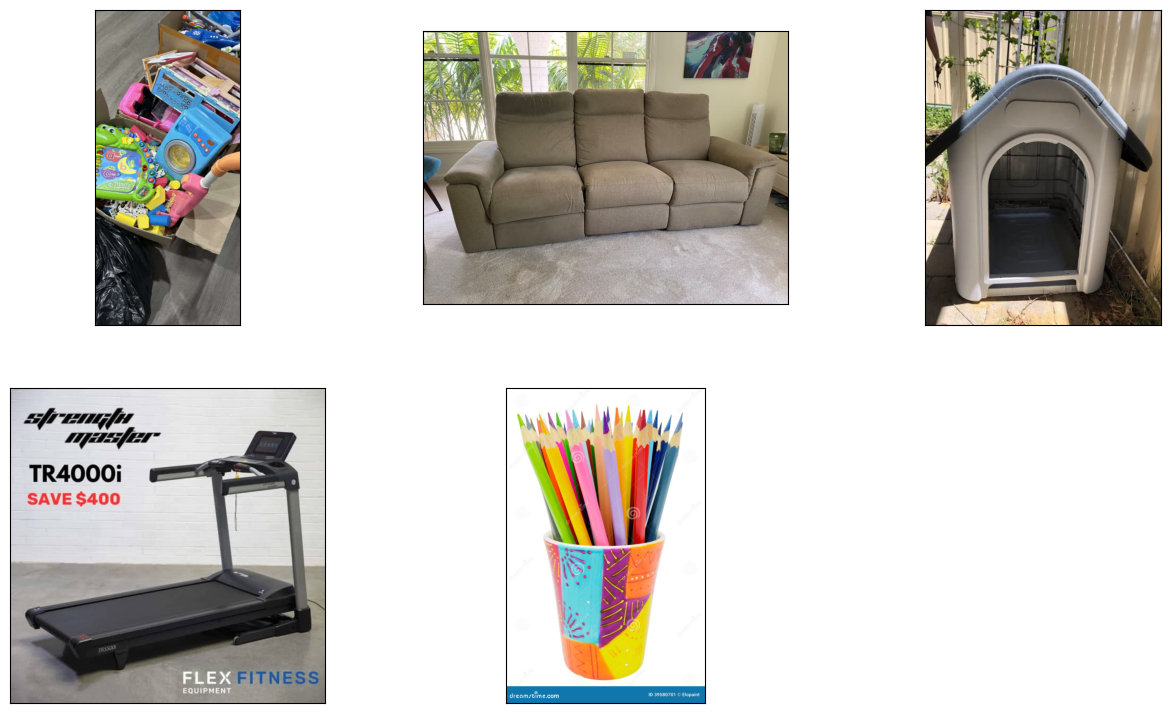

In [ ]:
## Plot images

from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir(IMAGE_FOLDER_PATH):
    print(img_path)
    image_paths.append(str(os.path.join(IMAGE_FOLDER_PATH, img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

## Initialize `GeminiMultiModal` and Load Images

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index import SimpleDirectoryReader


image_documents = SimpleDirectoryReader(IMAGE_FOLDER_PATH).load_data()

gemini_pro = GeminiMultiModal(model="models/gemini-pro")

## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [ ]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [ ]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


### Define the Pydantic Class for the Structured Parser

In [ ]:
from pydantic import BaseModel
from typing import List, Literal
from PIL import Image
import matplotlib.pyplot as plt

class Item(BaseModel):
    """Data model for an Item."""

    category: str
    subcategories: List[str]
    title: str
    description: str
    condition: Literal['NEW', 'OLD']  # Restrict to 'NEW' or 'OLD'


### Call the Pydantic Program and Generate Structured Output

In [ ]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

prompt_template_str = """\
    You are an expert at selling on gumtree people used items.
    Given an item photo, you will extract the characteristics as required in a json format\
    Pay attention to the title that needs to be catchy\
    Use the description for a verbose description of the item\
    return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [ ]:

results = []
for img_doc in image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        Item,
        [img_doc],
        prompt_template_str,
    )
    for r in pydantic_response:
        print(img_doc.image_path, r)
    results.append(pydantic_response)

/content/drive/MyDrive/Colab Notebooks/Images/bunch-colored-pencils-handmade-bright-cup-39580701.jpg ('category', 'Art & Craft')
/content/drive/MyDrive/Colab Notebooks/Images/bunch-colored-pencils-handmade-bright-cup-39580701.jpg ('subcategories', ['Drawing & Painting'])
/content/drive/MyDrive/Colab Notebooks/Images/bunch-colored-pencils-handmade-bright-cup-39580701.jpg ('title', 'Brand New 24 Colored Pencils Set for Drawing and Coloring')
/content/drive/MyDrive/Colab Notebooks/Images/bunch-colored-pencils-handmade-bright-cup-39580701.jpg ('description', 'This is a brand new set of 24 colored pencils. They are perfect for drawing and coloring. The colors are vibrant and the pencils are easy to use. They would be a great gift for any artist or crafter.')
/content/drive/MyDrive/Colab Notebooks/Images/bunch-colored-pencils-handmade-bright-cup-39580701.jpg ('condition', 'NEW')
/content/drive/MyDrive/Colab Notebooks/Images/kennel.jpg ('category', 'Pet Supplies')
/content/drive/MyDrive/Colab

ValidationError: ignored

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps`

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend Mythos Restaurant, known for its American cuisine and unique underwater theme. Overlooking Universal Studios' Inland Sea, this restaurant offers a captivating ambiance. After your meal, explore the nearby tourist attractions such as Universal's Islands of Adventure, Skull Island: Reign of Kong, The Wizarding World of Harry Potter, Jurassic Park River Adventure, and Hollywood Rip Ride Rockit, all located near Mythos Restaurant.
